In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import pandas as pd  # For reading Excel file
import os  # For file operations
from PIL import Image  # For image processing

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import joblib


In [26]:
reset_model_training = False
if reset_model_training:
    epoch_dict = {"initial_epoch":0}
    joblib.dump(epoch_dict,"epoch_dict")
    
    past_history = {"loss":[],"mean_iou":[]}
    joblib.dump(past_history,"past_history")
    
    if "human_seg_unet_checkpoint.h5" in os.listdir():
        os.remove("human_seg_unet_checkpoint.h5")

In [27]:
img_fold = r"D:\data\images\human_detection\img"
mask_fold = r"D:\data\images\human_detection\segment"
batch_size = 16


img_generator = image_dataset_from_directory(
    img_fold,
    image_size=(512, 512),
    batch_size=batch_size,
    label_mode=None,
    shuffle=False
)

mask_generator = image_dataset_from_directory(
    mask_fold,
    image_size=(512, 512),
    batch_size=batch_size,
    label_mode=None,
    shuffle=False
)

Found 290 files belonging to 1 classes.
Found 290 files belonging to 1 classes.


In [28]:
def preprocess(image):
    return tf.cast(image, tf.float32) / 255.0

def mask_preprocess(image):
    image = image[:,:,:,0]
    img = tf.cast(image, tf.float32) / 255.0
    return img

In [29]:
proc_img_dataset = (
    img_generator
    .map(preprocess)
    .unbatch()
    .batch(batch_size,drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

proc_mask_dataset = (
    mask_generator
    .map(mask_preprocess)
    .unbatch()
    .batch(batch_size,drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [30]:
combined_dataset = tf.data.Dataset.zip((proc_img_dataset, proc_mask_dataset))

In [31]:
j=0
for i in combined_dataset.take(2):
    
    if j>0:
        break
    else:
        print(type(i),len(i),i[0].shape,i[1].shape)
    j+=1    

<class 'tuple'> 2 (16, 512, 512, 3) (16, 512, 512)


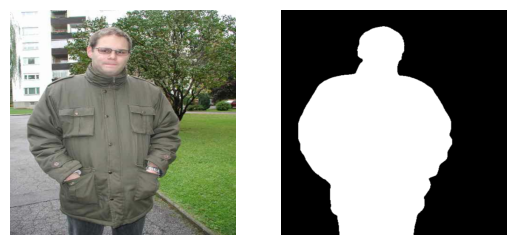

In [32]:
plt.subplot(121)
plt.imshow(i[0][1])
plt.axis("off")
plt.subplot(122)
plt.imshow(i[1][1],cmap="gray")
plt.axis("off");

In [33]:
def mean_iou(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [34]:
def build_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):

    img_inp = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(img_inp)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    
    model = Model(inputs=[img_inp], outputs=[outputs])
    optimizer = tf.keras.optimizers.Adam(lr=0.01)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[mean_iou])
    model.summary()
    
    return model

In [35]:
human_seg_unet_model = build_unet_model(512,512,3)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 512, 512, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

In [36]:
checkpoint_path = 'human_seg_unet_checkpoint.h5'

checkpoint_callback = ModelCheckpoint(  checkpoint_path,
                                                                    monitor='loss',
                                                                    save_best_only=True,
                                                                    mode='min',
                                                                    verbose=1   )

if os.path.exists(checkpoint_path):
    print("Checkpoint found! Resuming training from last epoch ...")
    human_seg_unet_model.load_weights(checkpoint_path)

Checkpoint found! Resuming training from last epoch ...


In [37]:
epoch_dict = joblib.load("epoch_dict")
past_history = joblib.load("past_history")

epochs = 10
initial_epoch = epoch_dict.get("initial_epoch")

history = human_seg_unet_model.fit( combined_dataset, 
                                                            batch_size=batch_size,
                                                            epochs=initial_epoch+epochs,
                                                            callbacks=[checkpoint_callback],
                                                            initial_epoch=initial_epoch )

#human_seg_unet_model.save("human_seg_unet_checkpoint.h5")

Epoch 181/190
     18/Unknown - 188s 10s/step - loss: 0.0195 - mean_iou: 0.8701
Epoch 181: loss improved from inf to 0.01953, saving model to human_seg_unet_checkpoint.h5
18/18 [==============================] - 189s 10s/step - loss: 0.0195 - mean_iou: 0.8701
Epoch 182/190
18/18 [==============================] - ETA: 0s - loss: 0.0183 - mean_iou: 0.8746 
Epoch 182: loss improved from 0.01953 to 0.01834, saving model to human_seg_unet_checkpoint.h5
18/18 [==============================] - 188s 10s/step - loss: 0.0183 - mean_iou: 0.8746
Epoch 183/190
18/18 [==============================] - ETA: 0s - loss: 0.0192 - mean_iou: 0.8721 
Epoch 183: loss did not improve from 0.01834
18/18 [==============================] - 185s 10s/step - loss: 0.0192 - mean_iou: 0.8721
Epoch 184/190
18/18 [==============================] - ETA: 0s - loss: 0.0209 - mean_iou: 0.8639 
Epoch 184: loss did not improve from 0.01834
18/18 [==============================] - 185s 10s/step - loss: 0.0209 - mean_iou: 0

In [38]:
epoch_dict = {
"initial_epoch":initial_epoch+epochs
}
joblib.dump(epoch_dict,"epoch_dict")
epoch_dict

{'initial_epoch': 190}

In [39]:
past_history_updated = {
    "loss":past_history.get("loss")+history.history.get("loss"),
    "mean_iou":past_history.get("mean_iou")+history.history.get("mean_iou")    
}

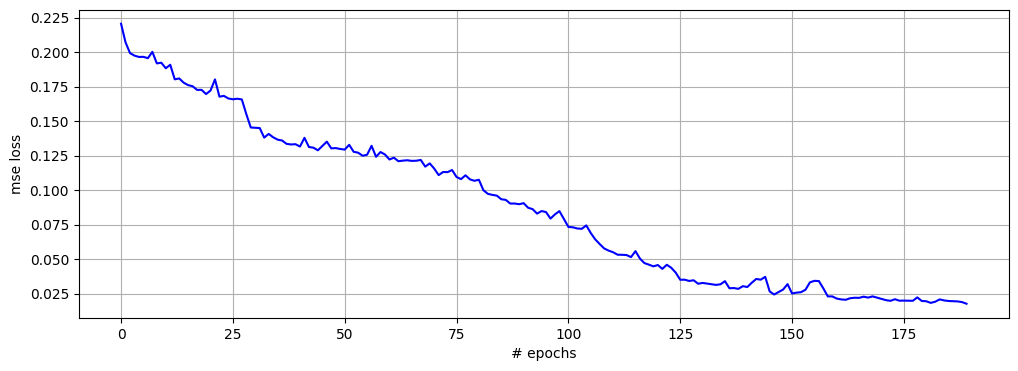

In [40]:
plt.figure(figsize=(12,4))
plt.xlabel("# epochs")
plt.ylabel("mse loss")
plt.plot(np.arange(0,len(past_history_updated.get("loss"))),past_history_updated.get("loss"),color="blue")
plt.grid(True);

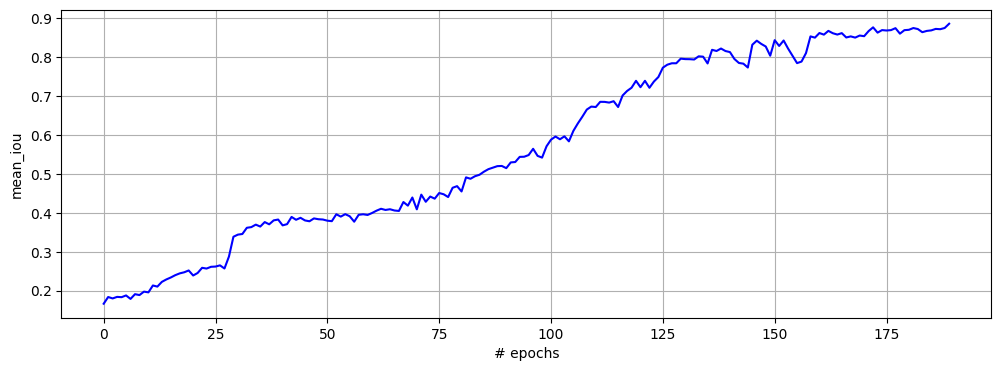

In [41]:
plt.figure(figsize=(12,4))
plt.xlabel("# epochs")
plt.ylabel("mean_iou")
plt.plot(np.arange(0,len(past_history_updated.get("mean_iou"))),past_history_updated.get("mean_iou"),color="blue")
plt.grid(True);

In [42]:
past_history_updated.keys()

dict_keys(['loss', 'mean_iou'])

In [43]:
joblib.dump(past_history_updated,"past_history")

['past_history']

In [44]:
preds = human_seg_unet_model.predict(i[0])

1/1 [==============================] - 2s 2s/step


In [45]:
preds[0].shape

(512, 512, 1)

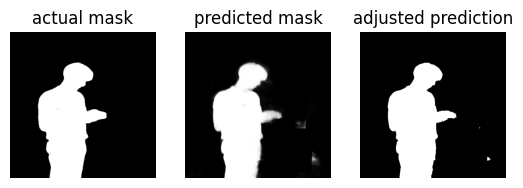

In [46]:
plt.subplot(131)
plt.imshow(i[1][0],cmap="gray");
plt.title("actual mask")
plt.axis("off")

plt.subplot(132)
plt.imshow(preds[0],cmap="gray");
plt.title("predicted mask")
plt.axis("off");

plt.subplot(133)
plt.imshow(np.where(preds[0]>0.5,1,0),cmap="gray");
plt.title("adjusted prediction")
plt.axis("off");

1/1 [==============================] - 0s 148ms/step


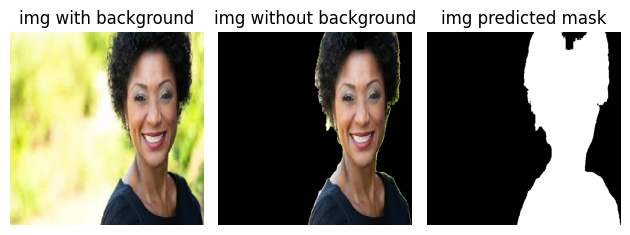

In [51]:
img_with_background = load_img(r"D:\data\images\human_detection\img\14.jpg",target_size=(512,512))
img_2_arr = img_to_array(img_with_background)/255.0
plt.subplot(131)
plt.title("img with background")
plt.imshow(img_2_arr);
plt.axis("off");
img_mask_pred = human_seg_unet_model.predict(img_2_arr.reshape(-1,512,512,3))
img_mask_final_pred = np.where(img_mask_pred>0.5,1,0).reshape(512,512)
img_without_background = img_2_arr * img_mask_final_pred[:, :, np.newaxis]
plt.subplot(132)
plt.imshow(img_without_background);
plt.title("img without background")
plt.axis("off");
plt.subplot(133)
plt.imshow(img_mask_final_pred,cmap="gray");
plt.title("img predicted mask")
plt.axis("off");
plt.tight_layout()